## Classification of skin cancer

## Loading the dataset

The dataset in processed for is too big to fit into memory *133 * 133 * 3 * float32*, even if we would use a data type with smaller precision. Our solution is to use tf.keras.utils.PyDataset as a base class for our dataset, and let it handle the dynamic loading of the data. The `create_dataset()` utility function uses this class to create a dataset object from the metadata that it receives.

However first, we are going to train an autoencoder model to create an embedding for our data, to which we can append the metadata. The `SkinCancerReconstructionDataset` object generates batches where the taget is the same as the input. It has a utility function as well: `create_reconstruction_dataset()`.

In [20]:
%pip install gdown
%pip install pathlib
%pip install keras_tuner
from preprocessing import download_data

# Download the dataset if needed
download_data()

import tensorflow as tf
print(tf.__version__)


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
2.17.0


In [21]:
%pip install keras-visualizer
from preprocessing import create_dataset, load_metadata, upsample_metadata,_preprocess_metadata,create_concat_dataset
from sklearn.model_selection import train_test_split
import pandas as pd


pd.options.mode.copy_on_write = True

metadata = load_metadata(.01)

#upsample the positive metadata to have a more balanced dataset
metadata = upsample_metadata(metadata, upsample_factor=5)

#preprocessing the metadata, e.g.: removing the unnecessary columns, normalizing the data, and converting the data to a numpy array. 
#We need to do this before splitting because the one hot encoding will be different for the train and test set if we do it after splitting
preprocessed_metadata,pipeline = _preprocess_metadata(metadata)

print(metadata.shape)
print(preprocessed_metadata.shape)

#splitting the data into train, test, and validation sets
metadata_train, metadata_test, preprocessed_train, preprocessed_test = train_test_split(metadata, preprocessed_metadata, test_size=0.3)
metadata_test, metadata_valid, preprocessed_test, preprocessed_valid = train_test_split(metadata_test, preprocessed_test, test_size=0.2)

metadata.head()


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/tf/preprocessing.py:139: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(METADATA_PATH, dtype={"target": "int8", "age_approx": "Int8"})


(4026, 18)
(4026, 34)


,isic_id,target,age_approx,sex,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaLBnorm,tbp_lv_location,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,upsampled
278442,ISIC_6973879,0,55,female,4.860199,14.305652,1.202750,9.819445,Right Leg - Lower,1.975645,98.141253,1.329585,3.306379,8.338364,1.007245,0.136691,140,0
215021,ISIC_5407194,0,40,male,6.492775,15.552040,1.169244,7.919746,Torso Back Middle Third,2.733918,63.174790,2.506184,3.226334,10.048680,0.987079,0.264865,150,0
209685,ISIC_5273739,0,85,male,4.803903,14.310570,0.852283,5.875575,Left Leg - Lower,2.050439,0.240933,2.093707,2.914916,8.291358,1.088047,0.239726,130,0
29648,ISIC_0802250,0,55,male,6.455245,18.917140,0.648035,5.859754,Torso Back Top Third,2.227870,15.339460,3.285190,1.857113,11.050550,0.592206,0.287234,135,0
323386,ISIC_8084953,0,70,male,14.787010,20.832470,2.521341,10.091990,Torso Back Middle Third,4.165149,0.013207,4.914307,7.929867,17.551360,2.765024,0.460039,130,0


In [22]:
# Load the dataset generators, every ds part contains the images and the preprocessed metadata
batch_size = 32
ds_train  = create_concat_dataset(metadata_train,preprocessed_train, batch_size)
ds_test = create_concat_dataset(metadata_test,preprocessed_test, batch_size)
ds_valid = create_concat_dataset(metadata_valid,preprocessed_valid, batch_size)


(2818, 34)
(966, 34)
(242, 34)


In [23]:
# Construct the input shape from the size of the images
# and the number of channels (RGB)

image_input_shape = (*ds_train[0][0][0].shape[1:3], 3)
meta_input_shape = (ds_train[0][0][1].shape[1:3])


print("image_input_shape:", image_input_shape)
print("meta_input_shape:", meta_input_shape)



image_input_shape: (133, 133, 3)
meta_input_shape: (34,)


### Model creation
In this section, we describe the designed models for the training session. The most important dataset consisted of images, supplemented by extensive metadata, which we aimed to incorporate into the project. To achieve this, we used two input fields:

1. **Image Processing**: For the images, we utilized the InceptionResNetV2 pre-trained network. This choice was motivated by its high accuracy (over 80%) and relatively compact network size, as detailed in the [Keras Applications API](https://keras.io/api/applications/).
2. **Metadata Processing**: For the metadata, we implemented a simple structure comprising two standard dense layers.

After processing the inputs through their respective networks, we concatenated the two outputs and added an additional dense layer to refine the combined representation.

To optimize hyperparameters, including those in the dense layers and the learning rate, we employed Keras Tuner.





#### Metadata model

In [24]:

from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2,preprocess_input,decode_predictions
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,BatchNormalization, Dropout, Concatenate, Conv2D,Input
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


def create_metadata_model(hp : kt.HyperParameters):
	meta_input = Input(shape=meta_input_shape)
	x = Dense(units=hp.Int('dense_1_units', min_value=9, max_value=45, step=9), activation='relu')(meta_input)
	x = Dense(units=hp.Int('dense_1_units', min_value=6, max_value=60, step=10), activation='relu')(x)
	
	return meta_input,x

#### CNN model

In [25]:
def create_cnn_model(hp: kt.HyperParameters):
    cnn_input = Input(shape=image_input_shape)
    base_model = InceptionResNetV2(weights='imagenet', include_top=False,input_tensor=cnn_input,input_shape=image_input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)

    return cnn_input, x, base_model



#### Concatenated model creation

In [26]:
import numpy as np

def topModel(hp: kt.HyperParameters):
    metadata_input, metadata_output= create_metadata_model(hp)
    cnn_input, cnn_output, cnn_model= create_cnn_model(hp);
    combined = Concatenate()([cnn_output,metadata_output])

    x = Dense(units=hp.Int('dense_1_units', min_value=10, max_value=80, step=16), activation="relu")(combined)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[cnn_input,metadata_input], outputs=predictions)

    for layer in cnn_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])), metrics=['accuracy','precision'],loss='binary_crossentropy')
    return model


### Training
This section details the training process, starting with the hyperparameter search for the new layers in the transfer learning setup. Subsequently, it covers the hyperparameter search for the base layers and the training process itself.

### Keras Tuner Hyperband settings + search

In [27]:
from kerastuner.tuners import Hyperband

tuner = Hyperband(
    topModel,
    objective='val_precision',
    factor=3,
    max_epochs=10,
    directory='output',
    project_name='topmodel_hyperband')

tuner.search(ds_train, epochs=20, validation_data=ds_valid, callbacks=[EarlyStopping(patience=5)])

Reloading Tuner from output/topmodel_hyperband/tuner0.json

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
9                 |45                |dense_1_units
0.01              |0.001             |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_3', 'keras_tensor']. Received: the structure of inputs=('*', '*')
  warnings.warn(
Process Keras_worker_ForkPoolWorker-301:
Process Keras_worker_ForkPoolWorker-302:
Process Keras_worker_ForkPoolWorker-300:
Process Keras_worker_ForkPoolWorker-304:
Process Keras_worker_ForkPoolWorker-305:
Process Keras_worker_ForkPoolWorker-303:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  Fil

KeyboardInterrupt: 

#### Base model training

I used the earlyCheckpoint callback for storing the best values, EarlyStopping, and also WanDB, to store and visualize the results

In [ ]:
import wandb



#run = wandb.init(project="skin-cancer-detection")

callbacks = [
    EarlyStopping(patience=20, start_from_epoch=20, restore_best_weights=True),
    ModelCheckpoint("resnet.keras", save_best_only=True),
    #wandb.keras.WandbMetricsLogger(),
    #wandb.keras.WandbModelCheckpoint("resnet.keras", save_best_only=True)
]
best_model = tuner.get_best_models(num_models=1)[0]
best_model.fit(ds_train, batch_size=batch_size, epochs=5, validation_data=ds_valid, callbacks=callbacks)



Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


89/89 ━━━━━━━━━━━━━━━━━━━━ 41s 356ms/step - accuracy: 0.9979 - loss: 3.7850 - precision: 0.3779 - val_accuracy: 0.9959 - val_loss: 0.0104 - val_precision: 0.5000
Epoch 2/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 32s 361ms/step - accuracy: 0.9962 - loss: 1.0691 - precision: 0.3067 - val_accuracy: 0.9959 - val_loss: 1.6383 - val_precision: 0.0000e+00
Epoch 3/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 32s 352ms/step - accuracy: 0.9694 - loss: 1.3639 - precision: 0.0970 - val_accuracy: 0.9959 - val_loss: 19.9283 - val_precision: 0.0000e+00
Epoch 4/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 30s 337ms/step - accuracy: 0.9896 - loss: 3.6838 - precision: 0.2089 - val_accuracy: 0.9835 - val_loss: 2.0335 - val_precision: 0.0000e+00
Epoch 5/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 30s 334ms/step - accuracy: 0.9639 - loss: 0.8173 - precision: 0.1100 - val_accuracy: 0.9959 - val_loss: 39.2311 - val_precision: 0.0000e+00


### Training the last layers of the used InceptionResNetV2


In [ ]:
def baseleyers(hp: kt.HyperParameters): 
    best_model.compile(optimizer=SGD(hp.Choice('learning_rate', values=[1e-5, 1e-6]), momentum=0.9), metrics=['accuracy'], loss='binary_crossentropy')
    return best_model



In [ ]:
for layer in best_model.layers[:350]:
       layer.trainable = False
for layer in best_model.layers[350:]:
       layer.trainable = True

tuner2 = Hyperband(
    baseleyers,
    objective='val_precision',
    factor=3,
    max_epochs=10,
    directory='output',
    project_name='base_layer_hyperband')

tuner2.search(ds_train, epochs=5, validation_data=ds_valid, callbacks=[EarlyStopping(patience=5)])
run.finish()


Trial 1 Complete [00h 03m 05s]

Best val_precision So Far: None
Total elapsed time: 00h 03m 05s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
1e-05             |1e-06             |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
89/89 ━━━━━━━━━━━━━━━━━━━━ 112s 958ms/step - accuracy: 0.8916 - loss: 8.1648 - val_accuracy: 0.1157 - val_loss: 10.7899
Epoch 2/2
18/89 ━━━━━━━━━━━━━━━━━━━━ 1:03 892ms/step - accuracy: 0.8690 - loss: 0.3435

Process Keras_worker_ForkPoolWorker-134:
Process Keras_worker_ForkPoolWorker-137:
Process Keras_worker_ForkPoolWorker-138:
Process Keras_worker_ForkPoolWorker-133:
Process Keras_worker_ForkPoolWorker-135:
Process Keras_worker_ForkPoolWorker-136:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/multiprocessing/process.py", line 10

Process Keras_worker_ForkPoolWorker-32:
Process Keras_worker_ForkPoolWorker-36:
Process Keras_worker_ForkPoolWorker-33:
Process Keras_worker_ForkPoolWorker-34:
Process Keras_worker_ForkPoolWorker-35:
Process Keras_worker_ForkPoolWorker-31:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    tas

KeyboardInterrupt: 

Process Keras_worker_ForkPoolWorker-146:
Process Keras_worker_ForkPoolWorker-148:
Process Keras_worker_ForkPoolWorker-144:
Process Keras_worker_ForkPoolWorker-139:
Process Keras_worker_ForkPoolWorker-142:
Process Keras_worker_ForkPoolWorker-141:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.11/multiprocessing/process

#### Optimizing the last layers

In [ ]:
model= tuner.get_best_models(num_models=1)[0]
model.fit(ds_train, batch_size=batch_size, epochs=5, validation_data=ds_valid, callbacks=callbacks)


KeyboardInterrupt: 

### Class weights

Positive samples are heavily under-represented, which needs to be balanced out. We use the following techniques to compensate:
* **Upsampling**<br>
    Datapoints which belong to the positive samples are added to the dataset multiple times. This is indicated by the `upscale_factor` <br>
    parameter when calling the `upscale_metata()` method.
* **Data augmenting**<br>
    To make the upsampled images more unique, some image augmentation techniques are applied. In particular horizontal and vertical mirroring <br>
    and cropping then rescaling the images. Either one or two methods are applied randomly.
* **Sample weights**<br>
    For each sample the loss function is evaluated using a corresponding weight, <br>
    which is higher for the positive samples. We use to following formula: $c_d / (2 * c_s)$, <br>
    where $c_d$ is the count of all samples and $c_s$ is the count of samples for a given class of labels.

In [28]:
ds_train.class_weights

{0: 0.5024964336661911, 1: 100.64285714285714}

## Calculate accuracy measurement
The last part of a model training is the evaluation, where we can evaluate the prediction of the model a non-training related data. Besides, I will show the connected confusion matrix to the project as well

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_prediction = model.predict(ds_test)
y_binary = (y_prediction > 0.5).astype(int)




/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_3', 'keras_tensor']. Received: the structure of inputs=('*', '*')
  warnings.warn(


31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 416ms/step


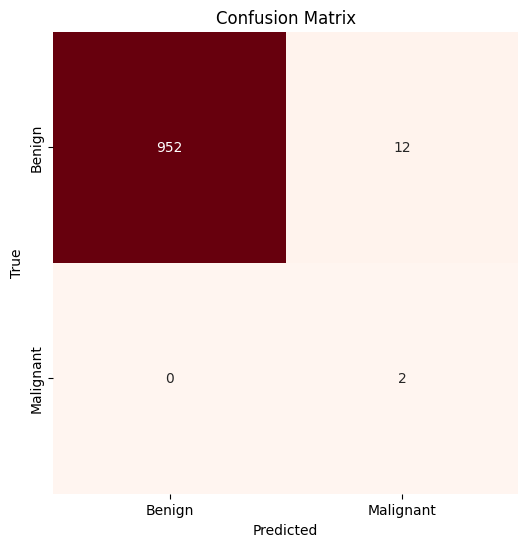

In [33]:
cm = confusion_matrix(ds_test.y, y_binary)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False, 
            xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


### Metrics
I will show here some of the most important metrics connected to the training<br>
In our current project probably the Recall metric is the most important one, because in our scenario the false negatives have a much bigger costs than false positives (a false positives can re-diagnosed, but the patients with a false negative results won't visit the doctors office)

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(ds_test.y, y_binary)
precision = precision_score(ds_test.y, y_binary)
recall = recall_score(ds_test.y, y_binary)
 
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

Accuracy: 0.9875776397515528
Precision: 0.14285714285714285
Recall: 1.0


In [ ]:
import gc
gc.collect()